In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('seaborn')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体（显示中文）
plt.rcParams['axes.unicode_minus'] = False

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

import warnings,datetime
warnings.filterwarnings('ignore')

from importlib import reload
import utils
reload(utils)
from utils import seed_everything,get_data
seed_everything(2023)

In [3]:
def outlier_detection_from_sigma_std(series,sigma=3):
    mean=series.mean()
    std=series.std()
    outlier_data=series[(series>mean+sigma*std)|((series<mean-sigma*std))].copy()
    return outlier_data
def outlier_detection_from_sigma_box_plot(series,sigma=3):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    gap = q3 - q1
    outlier_data=series[(series>q3+sigma*gap)|((series<q1-sigma*gap))].copy()
    return outlier_data
def outlier_detection_from_kde(series,threshold=0.001):
    # https://www.heywhale.com/mw/project/63fb0b0d7c8294eafa28e5f6
    from scipy.stats import gaussian_kde
    # Estimate the probability density function
    kde = gaussian_kde(series)

    # Compute the probability density for each data point
    probs = kde.pdf(series)

    # Find the anomalies (data points with probability density less than threshold)
    outlier_data = series.loc[probs < threshold]
    return outlier_data

# electricity

In [4]:
data,train,valid,test = get_data('electricity.csv')

# H0：具有单位根，属于非平稳序列。
# H1：没有单位根，属于平稳序列，说明这个序列不具有时间依赖型结构。

result = adfuller(train)
print('The ADF Statistic of yarn yield: %f' % result[0])
print('The p value of yarn yield: %f' % result[1])
# p < 0.05，拒绝原假设，即是平稳序列。

The ADF Statistic of yarn yield: -14.016658
The p value of yarn yield: 0.000000


In [5]:
# H0：序列的每个值是独立的，即纯随机
# H1：序列之间不是独立的，即存在相关性

acorr_ljungbox(train,lags=6,return_df=True)
# p < 0.05，拒绝原假设，即不是纯随机的。

,lb_stat,lb_pvalue
1,23574.852146,0.0
2,44202.446723,0.0
3,61591.680126,0.0
4,75649.726762,0.0
5,86620.260396,0.0
6,94933.877314,0.0


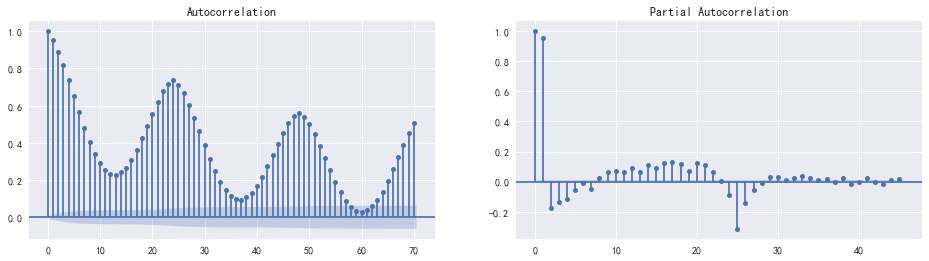

In [6]:
fig,ax=plt.subplots(1,2,figsize=(16,4))
plot_acf(train,ax=ax[0],lags=70) # 生成自相关图
plot_pacf(train,ax=ax[1]) # 生成偏自相关图
plt.show()
# 很强的周期性

In [8]:
# 非常耗内存，不推荐
# trend_evaluate = sm.tsa.arma_order_select_ic(train, ic=['aic', 'bic'], trend='nc', max_ar=5,max_ma=5)
# print('train AIC', trend_evaluate.aic_min_order)
# print('train BIC', trend_evaluate.bic_min_order)

from pmdarima.arima import AutoARIMA

auto_arima = AutoARIMA(start_p=1,d=0,start_q=1,max_p=5,max_q=5,trace=True,information_criterion='aic',random_state=2023)
auto_arima.fit(train)
auto_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=339800.166, Time=2.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=402118.829, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=340407.007, Time=0.86 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=375950.527, Time=3.57 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=496254.917, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=339359.626, Time=15.73 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=339617.352, Time=0.99 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=338975.325, Time=9.32 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=339121.217, Time=1.77 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=338735.528, Time=9.81 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=338752.460, Time=2.24 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=338683.456, Time=13.63 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=338681.690, Time=3.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=1.03 sec

Best mode

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                25992
Model:               SARIMAX(5, 0, 0)   Log Likelihood             -169333.845
Date:                Fri, 28 Apr 2023   AIC                         338681.690
Time:                        09:34:49   BIC                         338738.849
Sample:                    07-02-2016   HQIC                        338700.156
                         - 06-19-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    250.4559      5.970     41.950      0.000     238.754     262.158
ar.L1          1.0707      0.001    737.923      0.000       1.068       1.074
ar.L2         -0.0220      0.003     -7.626      0.000      -0.028      -0.016
ar.L3         -0.0088      0.006     -1.448      0.148      -0.021       0.003
ar.L4         -0.0621      0.006     -9.724      0.000      -0.075      -0.050
ar.L5         -0.0529      0.005    -11.375      0.000      -0.062      -0.044
sigma2      2.669e+04     52.379    509.463      0.000    2.66e+04    2.68e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):           6623933.49
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        81.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
data=pd.DataFrame(data).reset_index()
data['year']=data['date'].apply(lambda x:x.year)
data['month']=data['date'].apply(lambda x:x.month)
data['week']=data['date'].apply(lambda x:x.weekday()+1)
data['weeknum']=data['date'].apply(lambda x:x.isocalendar()[1])
data['day']=data['date'].apply(lambda x:x.day)
data['hour']=data['date'].apply(lambda x:x.hour)
data['quarter']=data['month'].apply(lambda x:(x-1)//3+1)
data.describe()

,OT,year,month,week,weeknum,day,hour,quarter
count,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000
mean,3336.427169,2017.498630,6.526027,4.001826,26.499543,15.720548,11.500000,2.509589
std,552.691775,0.957444,3.447917,2.002319,14.988066,8.796414,6.922318,1.116788
min,0.000000,2016.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,2921.000000,2017.000000,4.000000,2.000000,14.000000,8.000000,5.750000,2.000000
50%,3271.000000,2017.000000,7.000000,4.000000,26.000000,16.000000,11.500000,3.000000
75%,3632.250000,2018.000000,10.000000,6.000000,39.000000,23.000000,17.250000,4.000000
max,6035.000000,2019.000000,12.000000,7.000000,52.000000,31.000000,23.000000,4.000000


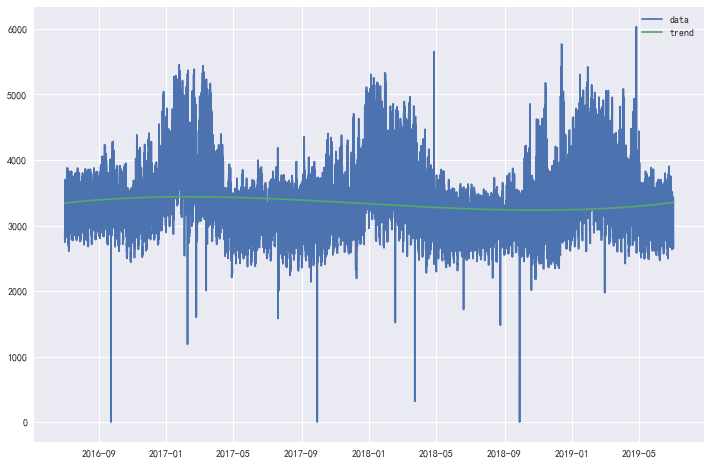

In [10]:
def get_trend(timeseries, deg=3):
	x = list(range(len(timeseries)))
	y = timeseries.values
	coef = np.polyfit(x, y, deg)
	trend = np.poly1d(coef)(x)
	return pd.Series(data=trend, index = timeseries.index)

plt.figure(figsize=(12,8))
plt.plot(data.set_index('date')['OT'],label='data')
plt.plot(get_trend(data.set_index('date')['OT']),label='trend')
plt.legend()
plt.show()
# 明显应该是有一些异常值的

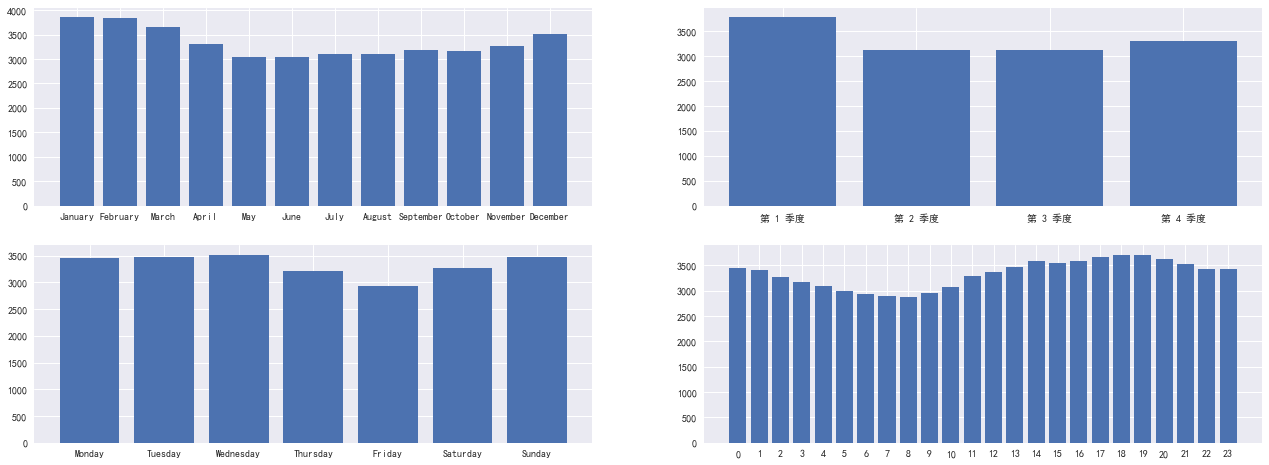

In [11]:
fig,ax=plt.subplots(2,2,figsize=(22,8))
tmp=data.sort_values('month').groupby(pd.to_datetime(data['date']).dt.month_name(),sort=False)['OT'].mean()
ax[0][0].bar(tmp.index,tmp.values.flatten())
tmp=data.sort_values('quarter').groupby('第 '+data['quarter'].astype(str)+' 季度',sort=False)['OT'].mean()
ax[0][1].bar(tmp.index,tmp.values.flatten())
tmp=data.sort_values('week').groupby(pd.to_datetime(data['date']).dt.day_name(),sort=False)['OT'].mean()
ax[1][0].bar(tmp.index,tmp.values.flatten())
tmp=data.groupby(data['hour'].astype(str),sort=False)['OT'].mean()
ax[1][1].bar(tmp.index,tmp.values.flatten())
plt.show()
# 变化都不大

# traffic

In [3]:
data,train,valid,test = get_data('traffic.csv')

# H0：具有单位根，属于非平稳序列。
# H1：没有单位根，属于平稳序列，说明这个序列不具有时间依赖型结构。

result = adfuller(train)
print('The ADF Statistic of yarn yield: %f' % result[0])
print('The p value of yarn yield: %f' % result[1])
# p < 0.05，拒绝原假设，即是平稳序列。

The ADF Statistic of yarn yield: -11.484197
The p value of yarn yield: 0.000000


In [4]:
# H0：序列的每个值是独立的，即纯随机
# H1：序列之间不是独立的，即存在相关性

acorr_ljungbox(train,lags=6,return_df=True)
# p < 0.05，拒绝原假设，即不是纯随机的。

,lb_stat,lb_pvalue
1,15287.723540,0.0
2,27048.807703,0.0
3,34705.243613,0.0
4,38592.312234,0.0
5,39774.902041,0.0
6,39806.515854,0.0


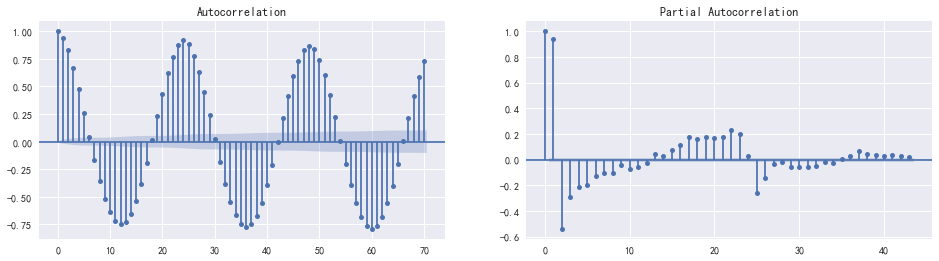

In [5]:
fig,ax=plt.subplots(1,2,figsize=(16,4))
plot_acf(train,ax=ax[0],lags=70) # 生成自相关图
plot_pacf(train,ax=ax[1]) # 生成偏自相关图
plt.show()
# 很强的周期性

In [6]:
# 非常耗内存，不推荐
# trend_evaluate = sm.tsa.arma_order_select_ic(train, ic=['aic', 'bic'], trend='nc', max_ar=5,max_ma=5)
# print('train AIC', trend_evaluate.aic_min_order)
# print('train BIC', trend_evaluate.bic_min_order)

from pmdarima.arima import AutoARIMA

auto_arima = AutoARIMA(start_p=1,d=0,start_q=1,max_p=5,max_q=5,trace=True,information_criterion='aic',random_state=2023)
auto_arima.fit(train)
auto_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-128131.266, Time=5.82 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-87118.387, Time=1.62 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-124695.405, Time=0.92 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-105607.415, Time=4.81 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-64805.108, Time=0.52 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-132373.205, Time=4.18 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-130628.244, Time=1.23 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-131804.262, Time=11.20 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-128800.335, Time=13.78 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-129438.411, Time=7.66 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-132126.411, Time=1.26 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-131501.368, Time=19.41 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-130235.490, Time=1.18 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit ti

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                17232
Model:               SARIMAX(2, 0, 1)   Log Likelihood               66191.602
Date:                Fri, 28 Apr 2023   AIC                        -132373.205
Time:                        09:11:38   BIC                        -132334.432
Sample:                    07-02-2016   HQIC                       -132360.427
                         - 06-19-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0032   5.13e-05     62.335      0.000       0.003       0.003
ar.L1          1.8639      0.004    464.854      0.000       1.856       1.872
ar.L2         -0.9657      0.004   -268.785      0.000      -0.973      -0.959
ma.L1         -0.5696      0.004   -137.104      0.000      -0.578      -0.561
sigma2      2.692e-05   5.48e-08    491.227      0.000    2.68e-05     2.7e-05
===================================================================================
Ljung-Box (L1) (Q):                  61.12   Jarque-Bera (JB):           7808726.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.68   Skew:                             0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                       107.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [8]:
data=pd.DataFrame(data).reset_index()
data['year']=data['date'].apply(lambda x:x.year)
data['month']=data['date'].apply(lambda x:x.month)
data['week']=data['date'].apply(lambda x:x.weekday()+1)
data['weeknum']=data['date'].apply(lambda x:x.isocalendar()[1])
data['day']=data['date'].apply(lambda x:x.day)
data['hour']=data['date'].apply(lambda x:x.hour)
data['quarter']=data['month'].apply(lambda x:(x-1)//3+1)
data.describe()

,OT,year,month,week,weeknum,day,hour,quarter
count,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000
mean,0.031555,2016.998630,6.526027,4.006849,26.498630,15.720548,11.500000,2.509589
std,0.019457,0.707126,3.447950,2.001757,14.988208,8.796498,6.922384,1.116799
min,0.000000,2016.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,0.012500,2016.000000,4.000000,2.000000,14.000000,8.000000,5.750000,2.000000
50%,0.034200,2017.000000,7.000000,4.000000,26.000000,16.000000,11.500000,3.000000
75%,0.046800,2017.000000,10.000000,6.000000,39.000000,23.000000,17.250000,4.000000
max,0.217400,2018.000000,12.000000,7.000000,52.000000,31.000000,23.000000,4.000000


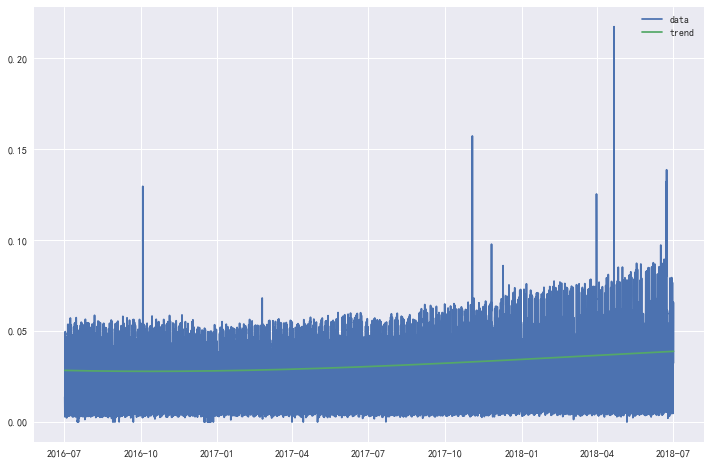

In [9]:
def get_trend(timeseries, deg=3):
	x = list(range(len(timeseries)))
	y = timeseries.values
	coef = np.polyfit(x, y, deg)
	trend = np.poly1d(coef)(x)
	return pd.Series(data=trend, index = timeseries.index)

plt.figure(figsize=(12,8))
plt.plot(data.set_index('date')['OT'],label='data')
plt.plot(get_trend(data.set_index('date')['OT']),label='trend')
plt.legend()
plt.show()
# 明显应该是有几个异常值的

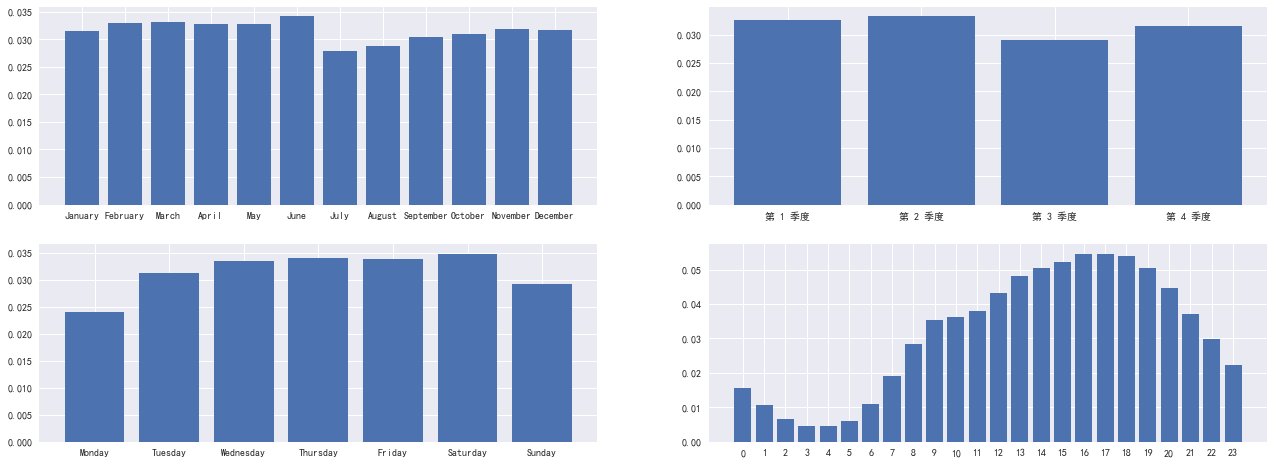

In [10]:
fig,ax=plt.subplots(2,2,figsize=(22,8))
tmp=data.sort_values('month').groupby(pd.to_datetime(data['date']).dt.month_name(),sort=False)['OT'].mean()
ax[0][0].bar(tmp.index,tmp.values.flatten())
tmp=data.sort_values('quarter').groupby('第 '+data['quarter'].astype(str)+' 季度',sort=False)['OT'].mean()
ax[0][1].bar(tmp.index,tmp.values.flatten())
tmp=data.sort_values('week').groupby(pd.to_datetime(data['date']).dt.day_name(),sort=False)['OT'].mean()
ax[1][0].bar(tmp.index,tmp.values.flatten())
tmp=data.groupby(data['hour'].astype(str),sort=False)['OT'].mean()
ax[1][1].bar(tmp.index,tmp.values.flatten())
plt.show()
# 所以没什么季节性的，但按小时算有很大的差异

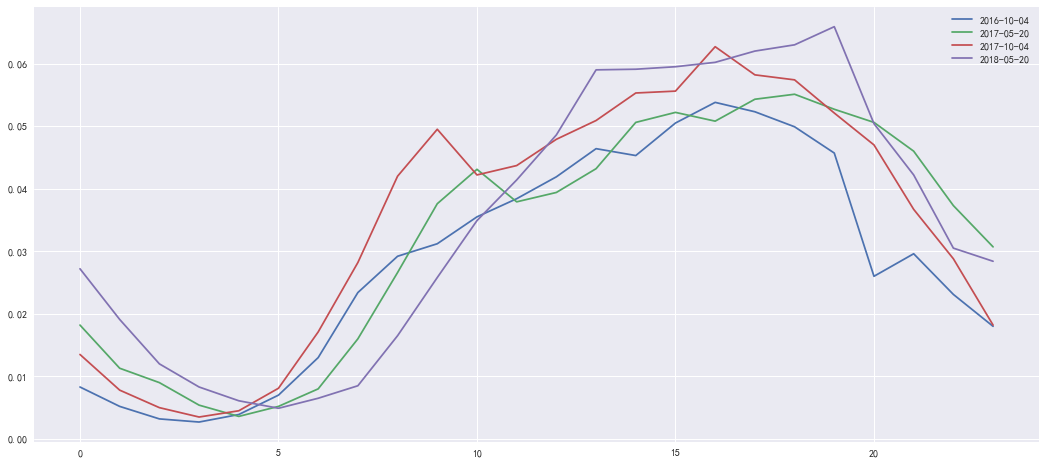

In [12]:
fig, ax = plt.subplots(figsize=(18, 8))
for date in pd.date_range(data['date'].min(),data['date'].max(),freq='d'):
	date=date.date()
	if date.isoformat() in ['2016-10-04','2017-10-04','2017-05-20','2018-05-20']:
		tmp=data[data['date'].between(f'{date} 00:00:00',f'{date} 23:00:00')].copy()
		plt.plot(tmp['hour'],tmp['OT'],label=date)

plt.legend()
plt.show()
# 不同的季节是没有什么区别的

In [27]:
from collections import Counter
outlier_date_counter=Counter()

for func,kwargs in zip([outlier_detection_from_sigma_std,outlier_detection_from_sigma_box_plot,
			outlier_detection_from_kde],[{},{},{'threshold':0.2}]):
	# if len(kwargs) == 0:
	# 	continue

	for year in data['year'].unique():
		outlier_data=func(data[data['year']==year].set_index('date')['OT'],**kwargs)
		outlier_date_counter += Counter({i:1 for i in outlier_data.index})

	# for quarter in data['quarter'].unique():
	# 	outlier_data=func(data[data['quarter']==quarter].set_index('date')['OT'],**kwargs)
	# 	outlier_date_counter += Counter({i:1 for i in outlier_data.index})

	# for month in data['month'].unique():
	# 	outlier_data=func(data[data['month']==month].set_index('date')['OT'],**kwargs)
	# 	outlier_date_counter += Counter({i:1 for i in outlier_data.index})

	# for weeknum in data['weeknum'].unique():
	# 	outlier_data=func(data[data['weeknum']==weeknum].set_index('date')['OT'],**kwargs)
	# 	outlier_date_counter += Counter({i:1 for i in outlier_data.index})

	for hour in data['hour'].unique():
		outlier_data=func(data[data['hour']==hour].set_index('date')['OT'],**kwargs)
		outlier_date_counter += Counter({i:1 for i in outlier_data.index})

sorted(outlier_date_counter.items(),key=lambda x:x[1],reverse=True)
# data.loc[data['date'].isin([i for i,j in outlier_date_counter.items() if j >= 10])]

[(Timestamp('2017-11-02 18:00:00'), 6),
 (Timestamp('2018-04-21 16:00:00'), 6),
 (Timestamp('2017-11-25 18:00:00'), 5),
 (Timestamp('2018-03-31 16:00:00'), 5),
 (Timestamp('2018-03-31 17:00:00'), 5),
 (Timestamp('2018-06-23 16:00:00'), 5),
 (Timestamp('2016-10-03 13:00:00'), 4),
 (Timestamp('2017-12-09 14:00:00'), 4),
 (Timestamp('2018-03-31 15:00:00'), 4),
 (Timestamp('2018-04-21 17:00:00'), 4),
 (Timestamp('2018-06-23 14:00:00'), 4),
 (Timestamp('2018-06-23 17:00:00'), 4),
 (Timestamp('2018-06-16 17:00:00'), 4),
 (Timestamp('2016-08-28 16:00:00'), 3),
 (Timestamp('2016-08-28 17:00:00'), 3),
 (Timestamp('2016-08-28 18:00:00'), 3),
 (Timestamp('2016-08-28 19:00:00'), 3),
 (Timestamp('2017-07-01 03:00:00'), 2),
 (Timestamp('2018-06-25 03:00:00'), 2),
 (Timestamp('2017-07-01 04:00:00'), 2),
 (Timestamp('2016-07-17 10:00:00'), 2),
 (Timestamp('2016-07-18 10:00:00'), 2),
 (Timestamp('2016-07-17 11:00:00'), 2),
 (Timestamp('2016-07-18 11:00:00'), 2),
 (Timestamp('2017-03-31 11:00:00'), 2),


In [28]:
data.loc[data['date'].isin([i for i,j in outlier_date_counter.items() if j >= 4])]

,date,OT,year,month,week,weeknum,day,hour,quarter
2245,2016-10-03 13:00:00,0.1296,2016,10,1,40,3,13,4
11730,2017-11-02 18:00:00,0.1573,2017,11,4,44,2,18,4
12282,2017-11-25 18:00:00,0.0978,2017,11,6,47,25,18,4
12614,2017-12-09 14:00:00,0.0860,2017,12,6,49,9,14,4
15303,2018-03-31 15:00:00,0.1254,2018,3,6,13,31,15,1
15304,2018-03-31 16:00:00,0.1090,2018,3,6,13,31,16,1
15305,2018-03-31 17:00:00,0.1064,2018,3,6,13,31,17,1
15808,2018-04-21 16:00:00,0.2174,2018,4,6,16,21,16,2
15809,2018-04-21 17:00:00,0.1329,2018,4,6,16,21,17,2
17153,2018-06-16 17:00:00,0.0973,2018,6,6,24,16,17,2


# ETTh1

In [37]:
data,train,valid,test = get_data('ETTh1.csv')

# H0：具有单位根，属于非平稳序列。
# H1：没有单位根，属于平稳序列，说明这个序列不具有时间依赖型结构。

result = adfuller(train)
print('The ADF Statistic of yarn yield: %f' % result[0])
print('The p value of yarn yield: %f' % result[1])
# p < 0.05，拒绝原假设，即是平稳序列。

The ADF Statistic of yarn yield: -3.466817
The p value of yarn yield: 0.008881


In [4]:
# H0：序列的每个值是独立的，即纯随机
# H1：序列之间不是独立的，即存在相关性

acorr_ljungbox(train,lags=6,return_df=True)
# p < 0.05，拒绝原假设，即不是纯随机的。

,lb_stat,lb_pvalue
1,16915.369167,0.0
2,33639.282420,0.0
3,50169.780520,0.0
4,66502.323565,0.0
5,82653.133227,0.0
6,98632.784349,0.0


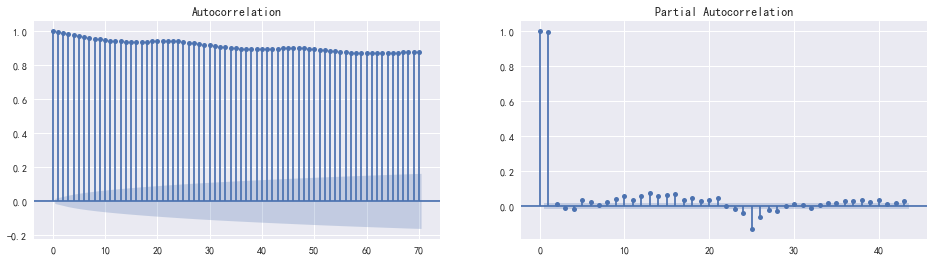

In [5]:
fig,ax=plt.subplots(1,2,figsize=(16,4))
plot_acf(train,ax=ax[0],lags=70) # 生成自相关图
plot_pacf(train,ax=ax[1]) # 生成偏自相关图
plt.show()

In [6]:
# 非常耗内存，不推荐
# trend_evaluate = sm.tsa.arma_order_select_ic(train, ic=['aic', 'bic'], trend='nc', max_ar=5,max_ma=5)
# print('train AIC', trend_evaluate.aic_min_order)
# print('train BIC', trend_evaluate.bic_min_order)

from pmdarima.arima import AutoARIMA

auto_arima = AutoARIMA(start_p=1,d=0,start_q=1,max_p=5,max_q=5,trace=True,information_criterion='aic',random_state=2023)
auto_arima.fit(train)
auto_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=45777.719, Time=1.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=122287.733, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=101091.849, Time=1.77 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=143313.929, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=45781.184, Time=3.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=45777.437, Time=1.48 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=86078.737, Time=3.41 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=45781.009, Time=7.01 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=45771.888, Time=1.95 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=76225.881, Time=6.22 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=45767.841, Time=9.13 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=45774.009, Time=9.77 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=45681.716, Time=16.75 sec
 ARIMA(1,0,4)(0,0,0)[

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                17112
Model:               SARIMAX(2, 0, 5)   Log Likelihood              -22828.710
Date:                Thu, 27 Apr 2023   AIC                          45675.420
Time:                        10:33:21   BIC                          45745.148
Sample:                    07-01-2016   HQIC                         45698.406
                         - 06-13-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0321      0.006      5.080      0.000       0.020       0.044
ar.L1          1.6641      0.042     39.568      0.000       1.582       1.747
ar.L2         -0.6664      0.042    -15.987      0.000      -0.748      -0.585
ma.L1         -0.6912      0.042    -16.276      0.000      -0.774      -0.608
ma.L2          0.0153      0.006      2.662      0.008       0.004       0.027
ma.L3         -0.0025      0.006     -0.400      0.689      -0.015       0.010
ma.L4         -0.0456      0.007     -6.808      0.000      -0.059      -0.032
ma.L5         -0.0331      0.007     -4.491      0.000      -0.048      -0.019
sigma2         0.8476      0.004    189.995      0.000       0.839       0.856
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):             38187.28
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
data=pd.DataFrame(data).reset_index()
data['year']=data['date'].apply(lambda x:x.year)
data['month']=data['date'].apply(lambda x:x.month)
data['week']=data['date'].apply(lambda x:x.weekday()+1)
data['weeknum']=data['date'].apply(lambda x:x.isocalendar()[1])
data['day']=data['date'].apply(lambda x:x.day)
data['hour']=data['date'].apply(lambda x:x.hour)
data['quarter']=data['month'].apply(lambda x:(x-1)//3+1)
data.describe()

,OT,year,month,week,weeknum,day,hour,quarter
count,17400.000000,17400.000000,17400.000000,17400.000000,17400.000000,17400.000000,17400.000000,17400.000000
mean,13.328873,2016.988966,6.529655,4.004138,26.502069,15.635862,11.500000,2.513103
std,8.570952,0.704598,3.459542,2.002466,15.039748,8.766478,6.922385,1.119839
min,-4.080000,2016.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,6.964000,2016.000000,4.000000,2.000000,13.000000,8.000000,5.750000,2.000000
50%,11.396000,2017.000000,7.000000,4.000000,27.000000,16.000000,11.500000,3.000000
75%,18.079000,2017.000000,10.000000,6.000000,40.000000,23.000000,17.250000,4.000000
max,46.007000,2018.000000,12.000000,7.000000,52.000000,31.000000,23.000000,4.000000


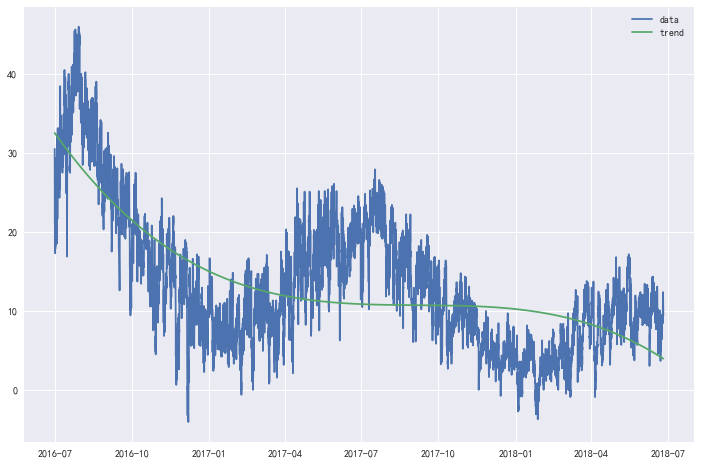

In [9]:
def get_trend(timeseries, deg=3):
	x = list(range(len(timeseries)))
	y = timeseries.values
	coef = np.polyfit(x, y, deg)
	trend = np.poly1d(coef)(x)
	return pd.Series(data=trend, index = timeseries.index)

plt.figure(figsize=(12,8))
plt.plot(data.set_index('date')['OT'],label='data')
plt.plot(get_trend(data.set_index('date')['OT']),label='trend')
plt.legend()
plt.show()
# 明显305.5是个异常值

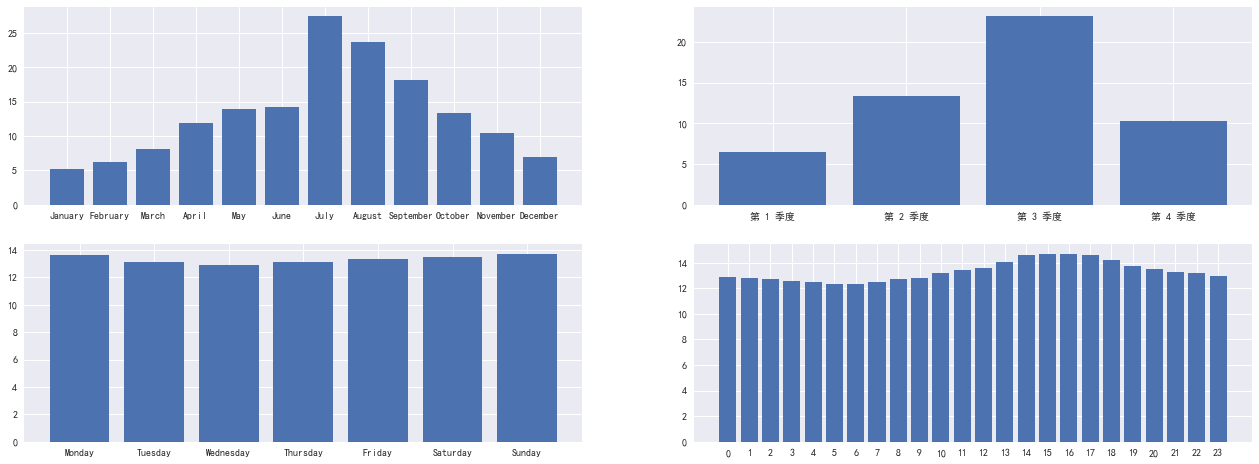

In [25]:
fig,ax=plt.subplots(2,2,figsize=(22,8))
tmp=data.sort_values('month').groupby(pd.to_datetime(data['date']).dt.month_name(),sort=False)['OT'].mean()
ax[0][0].bar(tmp.index,tmp.values.flatten())
tmp=data.sort_values('quarter').groupby('第 '+data['quarter'].astype(str)+' 季度',sort=False)['OT'].mean()
ax[0][1].bar(tmp.index,tmp.values.flatten())
tmp=data.sort_values('week').groupby(pd.to_datetime(data['date']).dt.day_name(),sort=False)['OT'].mean()
ax[1][0].bar(tmp.index,tmp.values.flatten())
tmp=data.groupby(data['hour'].astype(str),sort=False)['OT'].mean()
ax[1][1].bar(tmp.index,tmp.values.flatten())
plt.show()
# 所以是有季节性的，按小时算也有一点点差异

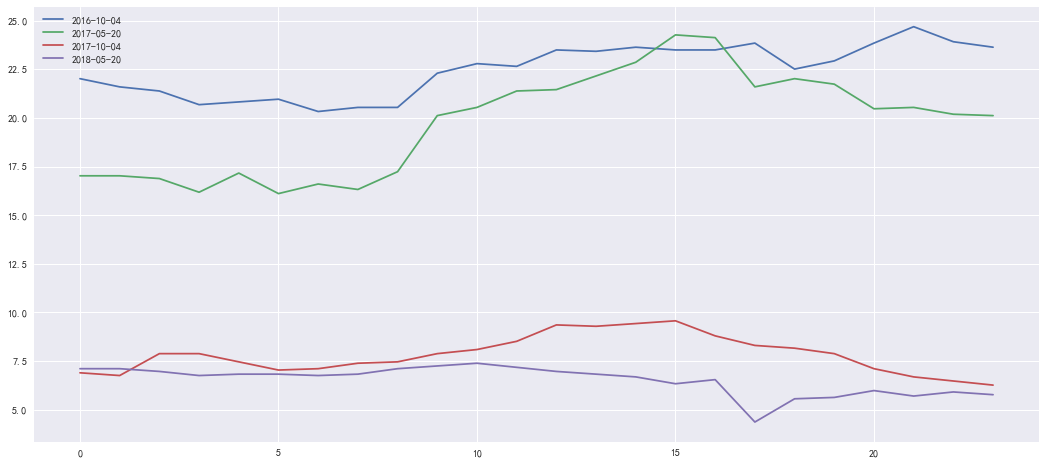

In [43]:
fig, ax = plt.subplots(figsize=(18, 8))
for date in pd.date_range(data['date'].min(),data['date'].max(),freq='d'):
	date=date.date()
	if date.isoformat() in ['2016-10-04','2017-10-04','2017-05-20','2018-05-20']:
		tmp=data[data['date'].between(f'{date} 00:00:00',f'{date} 23:00:00')].copy()
		plt.plot(tmp['hour'],tmp['OT'],label=date)

plt.legend()
plt.show()
# 不同的季节还是有点区别的

In [48]:
from collections import Counter
outlier_date_counter=Counter()

for func,kwargs in zip([outlier_detection_from_sigma_std,outlier_detection_from_sigma_box_plot,
			outlier_detection_from_kde],[{},{},{'threshold':0.0001}]):
	if len(kwargs) == 0:
		continue
	outlier_data=func(data.set_index('date')['OT'])
	outlier_date_counter += Counter({i:1 for i in outlier_data.index})

	# for year in data['year'].unique():
	# 	outlier_data=func(data[data['year']==year].set_index('date')['OT'],**kwargs)
	# 	outlier_date_counter += Counter({i:1 for i in outlier_data.index})

	# for quarter in data['quarter'].unique():
	# 	outlier_data=func(data[data['quarter']==quarter].set_index('date')['OT'],**kwargs)
	# 	outlier_date_counter += Counter({i:1 for i in outlier_data.index})

	# for month in data['month'].unique():
	# 	outlier_data=func(data[data['month']==month].set_index('date')['OT'],**kwargs)
	# 	outlier_date_counter += Counter({i:1 for i in outlier_data.index})

	# for weeknum in data['weeknum'].unique():
	# 	outlier_data=func(data[data['weeknum']==weeknum].set_index('date')['OT'],**kwargs)
	# 	outlier_date_counter += Counter({i:1 for i in outlier_data.index})

sorted(outlier_date_counter.items(),key=lambda x:x[1],reverse=True)
# data.loc[data['date'].isin([i for i,j in outlier_date_counter.items() if j >= 10])]

[(Timestamp('2016-07-24 08:00:00'), 1),
 (Timestamp('2016-07-24 09:00:00'), 1),
 (Timestamp('2016-07-24 15:00:00'), 1),
 (Timestamp('2016-07-24 16:00:00'), 1),
 (Timestamp('2016-07-24 17:00:00'), 1),
 (Timestamp('2016-07-24 18:00:00'), 1),
 (Timestamp('2016-07-25 08:00:00'), 1),
 (Timestamp('2016-07-25 09:00:00'), 1),
 (Timestamp('2016-07-25 15:00:00'), 1),
 (Timestamp('2016-07-25 16:00:00'), 1),
 (Timestamp('2016-07-25 17:00:00'), 1),
 (Timestamp('2016-07-25 18:00:00'), 1),
 (Timestamp('2016-07-26 15:00:00'), 1),
 (Timestamp('2016-07-26 16:00:00'), 1),
 (Timestamp('2016-07-26 17:00:00'), 1),
 (Timestamp('2016-07-26 18:00:00'), 1),
 (Timestamp('2016-07-27 16:00:00'), 1),
 (Timestamp('2016-07-27 17:00:00'), 1),
 (Timestamp('2016-07-28 15:00:00'), 1),
 (Timestamp('2016-07-28 16:00:00'), 1),
 (Timestamp('2016-07-28 17:00:00'), 1),
 (Timestamp('2016-07-28 18:00:00'), 1),
 (Timestamp('2016-07-29 08:00:00'), 1),
 (Timestamp('2016-07-29 14:00:00'), 1),
 (Timestamp('2016-07-29 15:00:00'), 1),


# exchange_rate

In [33]:
data,train,valid,test = get_data('exchange_rate.csv')

# H0：具有单位根，属于非平稳序列。
# H1：没有单位根，属于平稳序列，说明这个序列不具有时间依赖型结构。

result = adfuller(train)
print('The ADF Statistic of yarn yield: %f' % result[0])
print('The p value of yarn yield: %f' % result[1])
# p > 0.05，接受原假设，即是非平稳序列。

The ADF Statistic of yarn yield: -1.687127
The p value of yarn yield: 0.437757


In [11]:
# 所以做一阶差分看看
result = adfuller(train.diff(1).dropna())
print('The ADF Statistic of yarn yield: %f' % result[0])
print('The p value of yarn yield: %f' % result[1])
# p < 0.05，拒绝原假设，即一阶差分后是平稳序列。

The ADF Statistic of yarn yield: -52.090238
The p value of yarn yield: 0.000000


In [12]:
# H0：序列的每个值是独立的，即纯随机
# H1：序列之间不是独立的，即存在相关性

acorr_ljungbox(train.diff(1).dropna(),lags=6,return_df=True)
# p < 0.05，拒绝原假设，即不是纯随机的。

,lb_stat,lb_pvalue
1,18.416130,0.000018
2,18.455830,0.000098
3,22.915639,0.000042
4,23.451266,0.000103
5,23.839614,0.000233
6,24.940158,0.000350


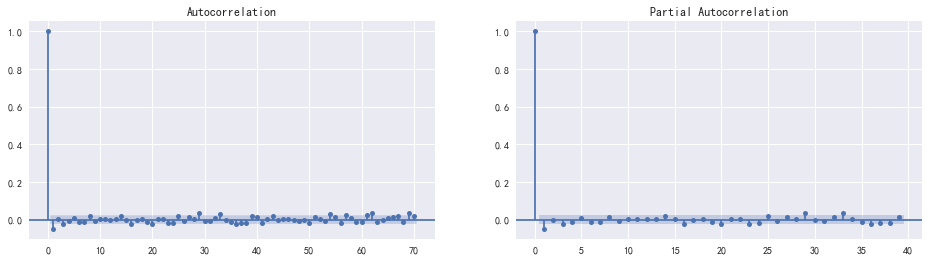

In [14]:
fig,ax=plt.subplots(1,2,figsize=(16,4))
plot_acf(train.diff(1).dropna(),ax=ax[0],lags=70) # 生成自相关图
plot_pacf(train.diff(1).dropna(),ax=ax[1]) # 生成偏自相关图
plt.show()

In [15]:
trend_evaluate = sm.tsa.arma_order_select_ic(train.diff(1).dropna(), ic=['aic', 'bic'], trend='nc', max_ar=5,max_ma=5)
print('train AIC', trend_evaluate.aic_min_order)
print('train BIC', trend_evaluate.bic_min_order)

train AIC (4, 5)
train BIC (0, 1)


In [16]:
from pmdarima.arima import AutoARIMA

auto_arima = AutoARIMA(start_p=1,d=1,start_q=1,max_p=5,max_q=5,trace=True,information_criterion='aic',random_state=2023)
auto_arima.fit(train)
auto_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-58724.441, Time=1.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-58710.012, Time=0.90 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-58726.441, Time=0.76 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-58726.446, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-58711.926, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-58724.433, Time=1.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-58722.366, Time=2.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-58728.351, Time=0.52 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-58726.347, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-58726.339, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-58728.346, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-58724.271, Time=0.47 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 9.433 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7517
Model:               SARIMAX(0, 1, 1)   Log Likelihood               29366.176
Date:                Wed, 26 Apr 2023   AIC                         -58728.351
Time:                        15:22:29   BIC                         -58714.502
Sample:                    01-01-1990   HQIC                        -58723.596
                         - 07-31-2010                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0495      0.004    -11.021      0.000      -0.058      -0.041
sigma2      2.365e-05   1.28e-07    184.957      0.000    2.34e-05    2.39e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            111268.40
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.71   Skew:                            -0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
data=pd.DataFrame(data).reset_index()
data['year']=data['date'].apply(lambda x:x.year)
data['month']=data['date'].apply(lambda x:x.month)
data['week']=data['date'].apply(lambda x:x.weekday()+1)
data['weeknum']=data['date'].apply(lambda x:x.isocalendar()[1])
data['day']=data['date'].apply(lambda x:x.day)
data['quarter']=data['month'].apply(lambda x:(x-1)//3+1)
data.describe()

,OT,year,month,week,weeknum,day,quarter
count,7578.000000,7578.000000,7578.000000,7578.000000,7578.000000,7578.000000,7578.000000
mean,0.654369,1999.878596,6.468725,3.999208,26.358802,15.727897,2.490499
std,0.115360,5.990383,3.432893,2.000066,15.000671,8.799820,1.111675
min,0.393153,1990.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.566000,1995.000000,3.250000,2.000000,13.000000,8.000000,1.250000
50%,0.668982,2000.000000,6.000000,4.000000,26.000000,16.000000,2.000000
75%,0.735283,2005.000000,9.000000,6.000000,39.000000,23.000000,3.000000
max,0.882379,2010.000000,12.000000,7.000000,53.000000,31.000000,4.000000


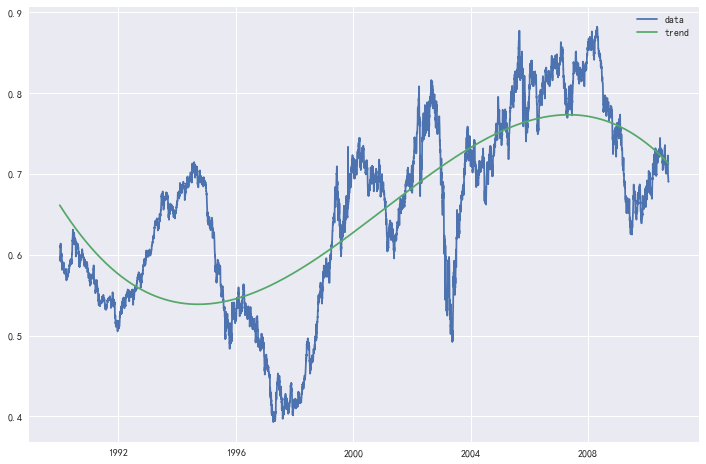

In [36]:
def get_trend(timeseries, deg=3):
	x = list(range(len(timeseries)))
	y = timeseries.values
	coef = np.polyfit(x, y, deg)
	trend = np.poly1d(coef)(x)
	return pd.Series(data=trend, index = timeseries.index)

plt.figure(figsize=(12,8))
plt.plot(data.set_index('date')['OT'],label='data')
plt.plot(get_trend(data.set_index('date')['OT']),label='trend')
plt.legend()
plt.show()

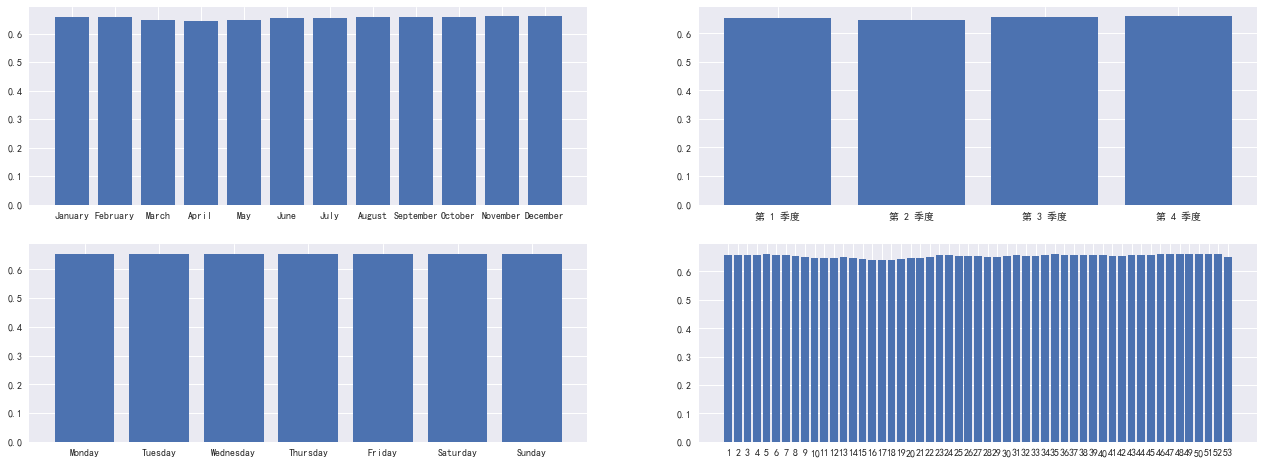

In [38]:
fig,ax=plt.subplots(2,2,figsize=(22,8))
tmp=data.groupby(pd.to_datetime(data['date']).dt.month_name(),sort=False)['OT'].mean()
ax[0][0].bar(tmp.index,tmp.values.flatten())
tmp=data.groupby('第 '+data['quarter'].astype(str)+' 季度',sort=False)['OT'].mean()
ax[0][1].bar(tmp.index,tmp.values.flatten())
tmp=data.groupby(pd.to_datetime(data['date']).dt.day_name(),sort=False)['OT'].mean()
ax[1][0].bar(tmp.index,tmp.values.flatten())
tmp=data.groupby(data['weeknum'].astype(str),sort=False)['OT'].mean()
ax[1][1].bar(tmp.index,tmp.values.flatten())
plt.show()
# 所以是没有季节性的，而且波动不大

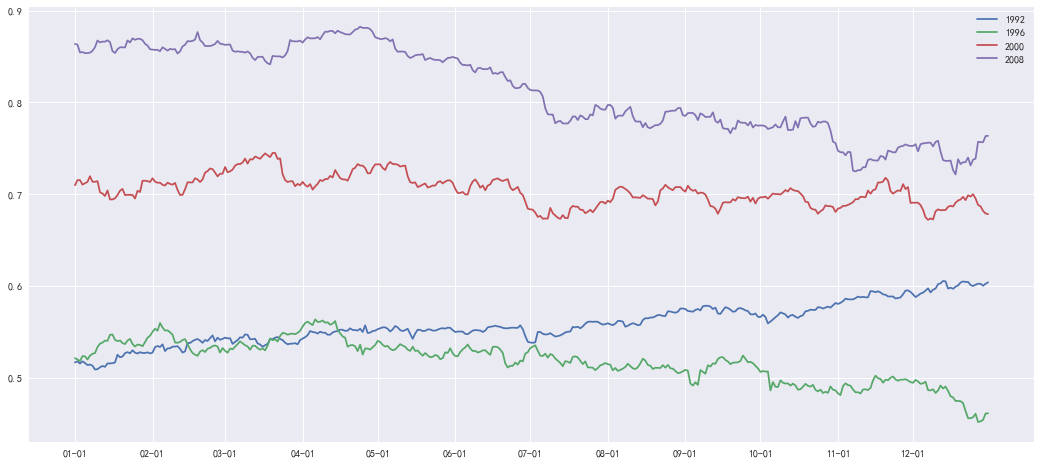

In [44]:
fig, ax = plt.subplots(figsize=(18, 8))
for year in data['year'].unique():
    if year in [1992,1996,2000,2008]:
        tmp=data[data['year']==year].copy()
        plt.plot(tmp['date'].apply(lambda x:x.strftime('%m-%d')),tmp['OT'],label=year)

plt.xticks([f'{i:02d}-01' for i in range(1,13)])
plt.legend()
plt.show()
# 不同年份区别很大

In [69]:
from collections import Counter
outlier_date_counter=Counter()

for func,kwargs in zip([outlier_detection_from_sigma_std,outlier_detection_from_sigma_box_plot,
			outlier_detection_from_kde],[{},{},{'threshold':0.9}]):
	outlier_data=func(data.set_index('date')['OT'])
	outlier_date_counter += Counter({i:1 for i in outlier_data.index})

	for year in data['year'].unique():
		outlier_data=func(data[data['year']==year].set_index('date')['OT'],**kwargs)
		outlier_date_counter += Counter({i:1 for i in outlier_data.index})

# sorted(outlier_date_counter.items(),key=lambda x:x[1],reverse=True)
data.loc[data['date'].isin([i for i,j in outlier_date_counter.items() if j >= 1])]

,date,OT,year,month,week,weeknum,day,quarter
3589,1999-10-30,0.733665,1999,10,6,43,30,4
4486,2002-04-14,0.672700,2002,4,7,15,14,2
5456,2004-12-09,0.795608,2004,12,4,50,9,4
5457,2004-12-10,0.795482,2004,12,5,50,10,4
5458,2004-12-11,0.795482,2004,12,6,50,11,4
5586,2005-04-18,0.718391,2005,4,1,16,18,2
5950,2006-04-17,0.749344,2006,4,1,16,17,2
5951,2006-04-18,0.750751,2006,4,2,16,18,2


In [70]:
data.loc[data['date'].isin([i for i,j in outlier_date_counter.items() if j >= 1]),'OT'] = np.nan
data['OT']=data['OT'].interpolate()
data.loc[data['date'].isin([i for i,j in outlier_date_counter.items() if j >= 1])]

,date,OT,year,month,week,weeknum,day,quarter
3589,1999-10-30,0.661950,1999,10,6,43,30,4
4486,2002-04-14,0.706575,2002,4,7,15,14,2
5456,2004-12-09,0.792539,2004,12,4,50,9,4
5457,2004-12-10,0.791489,2004,12,5,50,10,4
5458,2004-12-11,0.790440,2004,12,6,50,11,4
5586,2005-04-18,0.730193,2005,4,1,16,18,2
5950,2006-04-17,0.757234,2006,4,1,16,17,2
5951,2006-04-18,0.756317,2006,4,2,16,18,2


In [71]:
data[data['date'].between('2004-12-05','2004-12-15')]

,date,OT,year,month,week,weeknum,day,quarter
5452,2004-12-05,0.766284,2004,12,7,49,5,4
5453,2004-12-06,0.772201,2004,12,1,50,6,4
5454,2004-12-07,0.775555,2004,12,2,50,7,4
5455,2004-12-08,0.793588,2004,12,3,50,8,4
5456,2004-12-09,0.792539,2004,12,4,50,9,4
5457,2004-12-10,0.791489,2004,12,5,50,10,4
5458,2004-12-11,0.790440,2004,12,6,50,11,4
5459,2004-12-12,0.789391,2004,12,7,50,12,4
5460,2004-12-13,0.787402,2004,12,1,51,13,4
5461,2004-12-14,0.781067,2004,12,2,51,14,4


# weather

In [26]:
data,train,valid,test = get_data('weather.csv')

# H0：具有单位根，属于非平稳序列。
# H1：没有单位根，属于平稳序列，说明这个序列不具有时间依赖型结构。

result = adfuller(train)
print('The ADF Statistic of yarn yield: %f' % result[0])
print('The p value of yarn yield: %f' % result[1])
# p < 0.05，拒绝原假设，即是平稳序列。

The ADF Statistic of yarn yield: -28.878053
The p value of yarn yield: 0.000000


In [4]:
# H0：序列的每个值是独立的，即纯随机
# H1：序列之间不是独立的，即存在相关性

acorr_ljungbox(train,lags=6,return_df=True)
# p < 0.05，拒绝原假设，即不是纯随机的。

,lb_stat,lb_pvalue
1,51232.791152,0.0
2,101201.846219,0.0
3,149957.136334,0.0
4,197442.162293,0.0
5,243599.811962,0.0
6,288337.129463,0.0


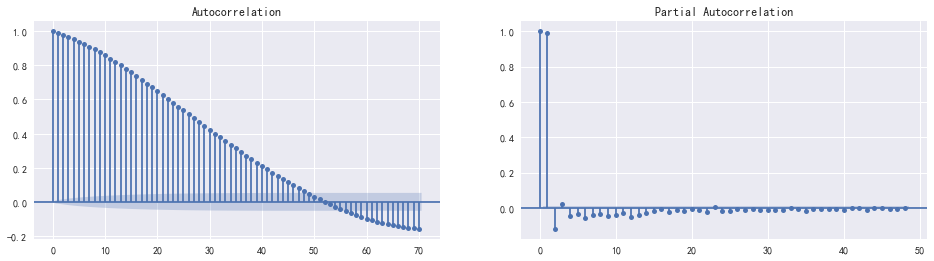

In [5]:
fig,ax=plt.subplots(1,2,figsize=(16,4))
plot_acf(train,ax=ax[0],lags=70) # 生成自相关图
plot_pacf(train,ax=ax[1]) # 生成偏自相关图
plt.show()

In [6]:
# 非常耗内存，不推荐
# trend_evaluate = sm.tsa.arma_order_select_ic(train, ic=['aic', 'bic'], trend='nc', max_ar=5,max_ma=5)
# print('train AIC', trend_evaluate.aic_min_order)
# print('train BIC', trend_evaluate.bic_min_order)

from pmdarima.arima import AutoARIMA

auto_arima = AutoARIMA(start_p=1,d=0,start_q=1,max_p=5,max_q=5,trace=True,information_criterion='aic',random_state=2023)
auto_arima.fit(train)
auto_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=249731.990, Time=13.43 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=455179.025, Time=0.59 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=250513.206, Time=1.27 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=391317.540, Time=5.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=781800.579, Time=0.30 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=249703.341, Time=18.91 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=249766.541, Time=2.03 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=249689.474, Time=35.48 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=249738.358, Time=2.79 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=249381.660, Time=43.07 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=249619.492, Time=3.09 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=249404.924, Time=51.57 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=249773.920, Time=48.20 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=249710.364, Time=38.69 se

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                52272
Model:               SARIMAX(4, 0, 1)   Log Likelihood             -124683.830
Date:                Tue, 25 Apr 2023   AIC                         249381.660
Time:                        13:44:44   BIC                         249443.709
Sample:                    01-02-2020   HQIC                        249401.056
                         - 12-29-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8038      0.097     28.860      0.000       2.613       2.994
ar.L1          1.8288      0.010    183.940      0.000       1.809       1.848
ar.L2         -0.9683      0.011    -85.365      0.000      -0.991      -0.946
ar.L3          0.2385      0.004     63.772      0.000       0.231       0.246
ar.L4         -0.1056      0.002    -51.463      0.000      -0.110      -0.102
ma.L1         -0.7142      0.010    -70.814      0.000      -0.734      -0.694
sigma2         6.8239      0.008    853.917      0.000       6.808       6.840
===================================================================================
Ljung-Box (L1) (Q):                   5.09   Jarque-Bera (JB):          27562249.28
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               2.33   Skew:                             1.55
Prob(H) (two-sided):                  0.00   Kurtosis:                       115.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
data=pd.DataFrame(data).reset_index()
data['year']=data['date'].apply(lambda x:x.year)
data['month']=data['date'].apply(lambda x:x.month)
data['week']=data['date'].apply(lambda x:x.weekday()+1)
data['weeknum']=data['date'].apply(lambda x:x.isocalendar()[1])
data['day']=data['date'].apply(lambda x:x.day)
data['hour']=data['date'].apply(lambda x:x.hour)
data['minute']=data['date'].apply(lambda x:x.minute)
data['quarter']=data['month'].apply(lambda x:(x-1)//3+1)
data.describe()

,OT,year,month,week,weeknum,day,hour,minute,quarter
count,52560.000000,52560.0,52560.000000,52560.000000,52560.00000,52560.00000,52560.000000,52560.000000,52560.000000
mean,427.644809,2020.0,6.528767,4.000000,27.00000,15.79726,11.500000,25.000000,2.509589
std,18.771448,0.0,3.443887,1.997277,15.05784,8.78971,6.922252,17.078414,1.116778
min,305.500000,2020.0,1.000000,1.000000,1.00000,1.00000,0.000000,0.000000,1.000000
25%,415.500000,2020.0,4.000000,2.000000,14.00000,8.00000,5.750000,10.000000,2.000000
50%,423.100000,2020.0,7.000000,4.000000,27.00000,16.00000,11.500000,25.000000,3.000000
75%,437.100000,2020.0,10.000000,6.000000,40.00000,23.00000,17.250000,40.000000,4.000000
max,524.200000,2020.0,12.000000,7.000000,53.00000,31.00000,23.000000,50.000000,4.000000


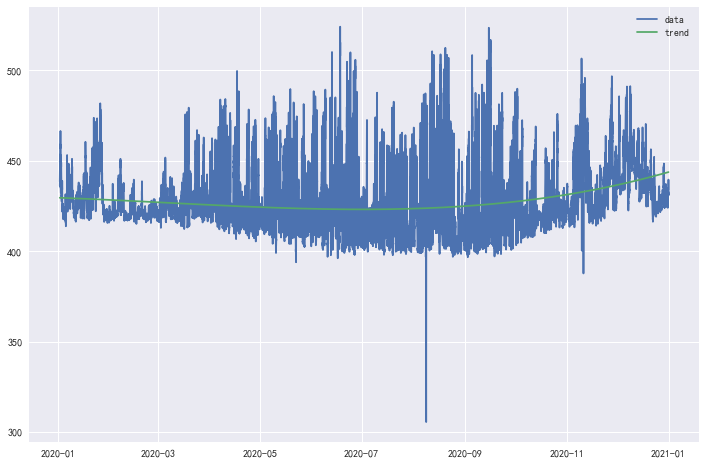

In [8]:
def get_trend(timeseries, deg=3):
	x = list(range(len(timeseries)))
	y = timeseries.values
	coef = np.polyfit(x, y, deg)
	trend = np.poly1d(coef)(x)
	return pd.Series(data=trend, index = timeseries.index)

plt.figure(figsize=(12,8))
plt.plot(data.set_index('date')['OT'],label='data')
plt.plot(get_trend(data.set_index('date')['OT']),label='trend')
plt.legend()
plt.show()
# 明显305.5是个异常值

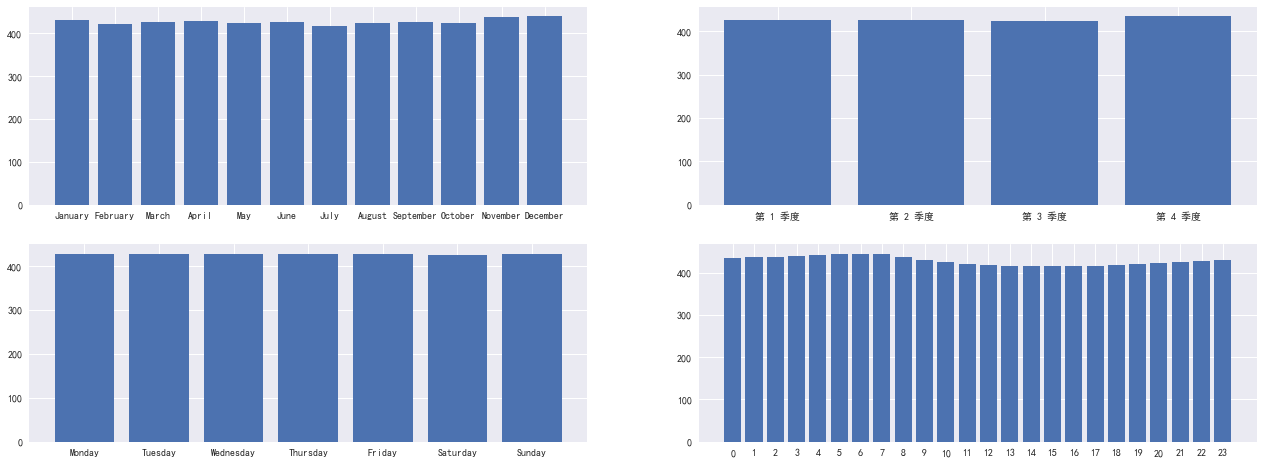

In [28]:
fig,ax=plt.subplots(2,2,figsize=(22,8))
tmp=data.sort_values('month').groupby(pd.to_datetime(data['date']).dt.month_name(),sort=False)['OT'].mean()
ax[0][0].bar(tmp.index,tmp.values.flatten())
tmp=data.sort_values('quarter').groupby('第 '+data['quarter'].astype(str)+' 季度',sort=False)['OT'].mean()
ax[0][1].bar(tmp.index,tmp.values.flatten())
tmp=data.sort_values('week').groupby(pd.to_datetime(data['date']).dt.day_name(),sort=False)['OT'].mean()
ax[1][0].bar(tmp.index,tmp.values.flatten())
tmp=data.groupby(data['hour'].astype(str),sort=False)['OT'].mean()
ax[1][1].bar(tmp.index,tmp.values.flatten())
plt.show()
# 所以是没有季节性的，而且波动不大

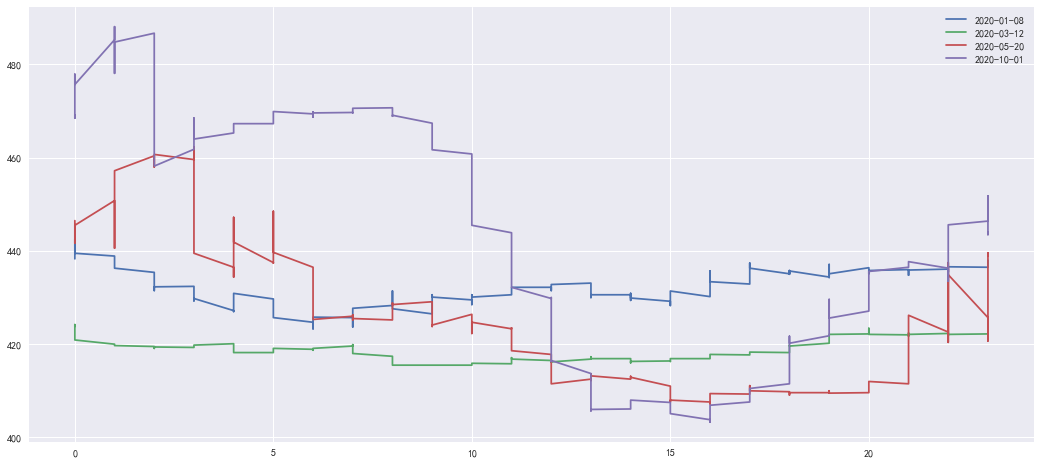

In [10]:
fig, ax = plt.subplots(figsize=(18, 8))
for date in pd.date_range(data['date'].min(),data['date'].max(),freq='d'):
	date=date.date()
	if date.isoformat() in ['2020-01-08','2020-03-12','2020-05-20','2020-10-01']:
		tmp=data[data['date'].between(f'{date} 00:00:00',f'{date} 23:50:00')].copy()
		plt.plot(tmp['hour'],tmp['OT'],label=date)

plt.legend()
plt.show()
# 不同的季节还是有点区别的

In [11]:
from collections import Counter
outlier_date_counter=Counter()

for func,kwargs in zip([outlier_detection_from_sigma_std,outlier_detection_from_sigma_box_plot,
			outlier_detection_from_kde],[{},{},{'threshold':0.0001}]):
	outlier_data=func(data.set_index('date')['OT'])
	outlier_date_counter += Counter({i:1 for i in outlier_data.index})

	for year in data['year'].unique():
		outlier_data=func(data[data['year']==year].set_index('date')['OT'],**kwargs)
		outlier_date_counter += Counter({i:1 for i in outlier_data.index})

	for quarter in data['quarter'].unique():
		outlier_data=func(data[data['quarter']==quarter].set_index('date')['OT'],**kwargs)
		outlier_date_counter += Counter({i:1 for i in outlier_data.index})

	for month in data['month'].unique():
		outlier_data=func(data[data['month']==month].set_index('date')['OT'],**kwargs)
		outlier_date_counter += Counter({i:1 for i in outlier_data.index})

	for weeknum in data['weeknum'].unique():
		outlier_data=func(data[data['weeknum']==weeknum].set_index('date')['OT'],**kwargs)
		outlier_date_counter += Counter({i:1 for i in outlier_data.index})

# sorted(outlier_date_counter.items(),key=lambda x:x[1],reverse=True)
data.loc[data['date'].isin([i for i,j in outlier_date_counter.items() if j >= 10])]

,date,OT,year,month,week,weeknum,day,hour,minute,quarter
23505,2020-06-13 05:30:00,509.400000,2020,6,6,24,13,5,30,2
23506,2020-06-13 05:40:00,510.200000,2020,6,6,24,13,5,40,2
24209,2020-06-18 02:50:00,518.800000,2020,6,4,25,18,2,50,2
24210,2020-06-18 03:00:00,522.300000,2020,6,4,25,18,3,0,2
24211,2020-06-18 03:10:00,521.200000,2020,6,4,25,18,3,10,2
24212,2020-06-18 03:20:00,523.100000,2020,6,4,25,18,3,20,2
24213,2020-06-18 03:30:00,524.200000,2020,6,4,25,18,3,30,2
24214,2020-06-18 03:40:00,522.200000,2020,6,4,25,18,3,40,2
24215,2020-06-18 03:50:00,519.400000,2020,6,4,25,18,3,50,2
24217,2020-06-18 04:10:00,514.300000,2020,6,4,25,18,4,10,2


In [12]:
data.loc[data['date'].isin([i for i,j in outlier_date_counter.items() if j >= 10]),'OT'] = np.nan
data['OT']=data['OT'].interpolate()
data.loc[data['date'].isin([i for i,j in outlier_date_counter.items() if j >= 10])]

,date,OT,year,month,week,weeknum,day,hour,minute,quarter
23505,2020-06-13 05:30:00,498.733333,2020,6,6,24,13,5,30,2
23506,2020-06-13 05:40:00,497.866667,2020,6,6,24,13,5,40,2
24209,2020-06-18 02:50:00,508.187500,2020,6,4,25,18,2,50,2
24210,2020-06-18 03:00:00,508.175000,2020,6,4,25,18,3,0,2
24211,2020-06-18 03:10:00,508.162500,2020,6,4,25,18,3,10,2
24212,2020-06-18 03:20:00,508.150000,2020,6,4,25,18,3,20,2
24213,2020-06-18 03:30:00,508.137500,2020,6,4,25,18,3,30,2
24214,2020-06-18 03:40:00,508.125000,2020,6,4,25,18,3,40,2
24215,2020-06-18 03:50:00,508.112500,2020,6,4,25,18,3,50,2
24217,2020-06-18 04:10:00,507.225000,2020,6,4,25,18,4,10,2


In [13]:
data[data['date'].between('2020-06-13 05:00:00','2020-06-13 06:20:00')]

,date,OT,year,month,week,weeknum,day,hour,minute,quarter
23502,2020-06-13 05:00:00,482.200000,2020,6,6,24,13,5,0,2
23503,2020-06-13 05:10:00,483.000000,2020,6,6,24,13,5,10,2
23504,2020-06-13 05:20:00,499.600000,2020,6,6,24,13,5,20,2
23505,2020-06-13 05:30:00,498.733333,2020,6,6,24,13,5,30,2
23506,2020-06-13 05:40:00,497.866667,2020,6,6,24,13,5,40,2
23507,2020-06-13 05:50:00,497.000000,2020,6,6,24,13,5,50,2
23508,2020-06-13 06:00:00,494.800000,2020,6,6,24,13,6,0,2
23509,2020-06-13 06:10:00,488.000000,2020,6,6,24,13,6,10,2
23510,2020-06-13 06:20:00,492.000000,2020,6,6,24,13,6,20,2


# daily_min_temperatures

In [29]:
data,train,valid,test = get_data()

# H0：具有单位根，属于非平稳序列。
# H1：没有单位根，属于平稳序列，说明这个序列不具有时间依赖型结构。

result = adfuller(train)
print('The ADF Statistic of yarn yield: %f' % result[0])
print('The p value of yarn yield: %f' % result[1])
# p < 0.05，拒绝原假设，即是平稳序列。

The ADF Statistic of yarn yield: -4.399615
The p value of yarn yield: 0.000297


In [3]:
# H0：序列的每个值是独立的，即纯随机
# H1：序列之间不是独立的，即存在相关性

acorr_ljungbox(train,lags=6,return_df=True)
# p < 0.05，拒绝原假设，即不是纯随机的。

,lb_stat,lb_pvalue
1,2155.715353,0.0
2,3585.670139,0.0
3,4822.437957,0.0
4,6032.492003,0.0
5,7241.842296,0.0
6,8440.751755,0.0


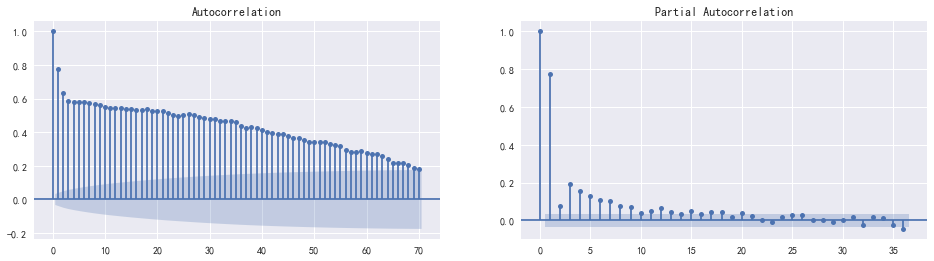

In [4]:
fig,ax=plt.subplots(1,2,figsize=(16,4))
plot_acf(train,ax=ax[0],lags=70) # 生成自相关图
plot_pacf(train,ax=ax[1]) # 生成偏自相关图
plt.show()

In [5]:
trend_evaluate = sm.tsa.arma_order_select_ic(train, ic=['aic', 'bic'], trend='nc', max_ar=5,max_ma=5)
print('train AIC', trend_evaluate.aic_min_order)
print('train BIC', trend_evaluate.bic_min_order)

train AIC (3, 5)
train BIC (3, 1)


In [6]:
from pmdarima.arima import AutoARIMA

auto_arima = AutoARIMA(start_p=1,start_q=1,max_p=5,max_q=5,trace=True,information_criterion='aic',random_state=2023)
auto_arima.fit(train)
auto_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=16949.425, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=20291.801, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=16996.559, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=18267.064, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=27956.992, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=16565.114, Time=1.73 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=16977.031, Time=0.38 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=16511.070, Time=2.52 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=16843.981, Time=0.57 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=16513.068, Time=2.88 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=16513.957, Time=2.84 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=16514.846, Time=1.82 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=16759.388, Time=0.76 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=16514.946, Time=1.91 sec
 ARIMA(3,0,1)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3591
Model:               SARIMAX(3, 0, 1)   Log Likelihood               -8249.535
Date:                Fri, 14 Apr 2023   AIC                          16511.070
Time:                        13:55:42   BIC                          16548.187
Sample:                    01-01-1981   HQIC                         16524.299
                         - 10-31-1990                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0565      0.018      3.111      0.002       0.021       0.092
ar.L1          1.4831      0.019     79.532      0.000       1.447       1.520
ar.L2         -0.6202      0.027    -23.240      0.000      -0.673      -0.568
ar.L3          0.1322      0.018      7.429      0.000       0.097       0.167
ma.L1         -0.8919      0.012    -74.861      0.000      -0.915      -0.869
sigma2         5.7905      0.129     45.017      0.000       5.538       6.043
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                16.56
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.08
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
data=pd.DataFrame(data).reset_index()
data['year']=data['Date'].apply(lambda x:x.year)
data['month']=data['Date'].apply(lambda x:x.month)
data['week']=data['Date'].apply(lambda x:x.weekday()+1)
data['weeknum']=data['Date'].apply(lambda x:x.isocalendar()[1])
data['day']=data['Date'].apply(lambda x:x.day)
data['quarter']=data['month'].apply(lambda x:(x-1)//3+1)
data['date']=data['Date'].apply(lambda x:x.strftime('%m-%d'))
data.describe()

,Temp,year,month,week,weeknum,day,quarter
count,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000
mean,11.179587,1985.500274,6.523549,4.000821,26.615553,15.727820,2.508762
std,4.071482,2.872293,3.449005,2.000479,15.063021,8.800529,1.117172
min,0.000000,1981.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,8.300000,1983.000000,4.000000,2.000000,14.000000,8.000000,2.000000
50%,11.000000,1985.500000,7.000000,4.000000,27.000000,16.000000,3.000000
75%,14.000000,1988.000000,10.000000,6.000000,40.000000,23.000000,4.000000
max,26.300000,1990.000000,12.000000,7.000000,53.000000,31.000000,4.000000


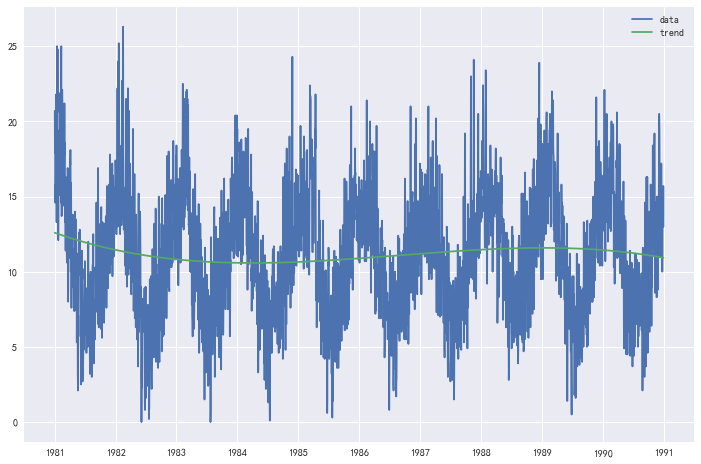

In [8]:
def get_trend(timeseries, deg=3):
	x = list(range(len(timeseries)))
	y = timeseries.values
	coef = np.polyfit(x, y, deg)
	trend = np.poly1d(coef)(x)
	return pd.Series(data=trend, index = timeseries.index)

plt.figure(figsize=(12,8))
plt.plot(data.set_index('Date')['Temp'],label='data')
plt.plot(get_trend(data.set_index('Date')['Temp']),label='trend')
plt.legend()
plt.show()

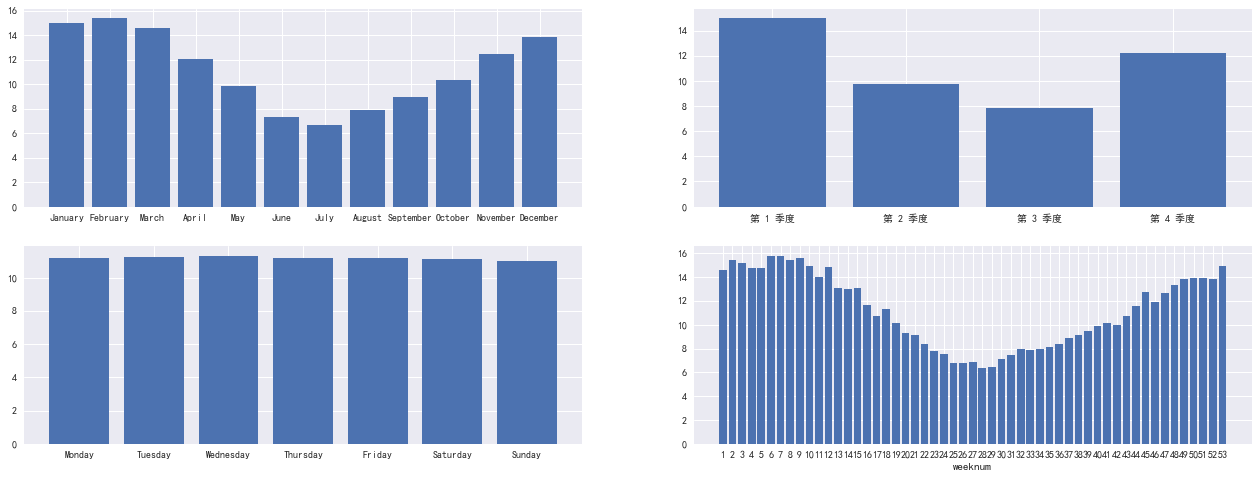

In [35]:
fig,ax=plt.subplots(2,2,figsize=(22,8))
tmp=data.sort_values('month').groupby(pd.to_datetime(data['Date']).dt.month_name(),sort=False)['Temp'].mean()
ax[0][0].bar(tmp.index,tmp.values.flatten())
tmp=data.sort_values('quarter').groupby('第 '+data['quarter'].astype(str)+' 季度',sort=False)['Temp'].mean()
ax[0][1].bar(tmp.index,tmp.values.flatten())
tmp=data.sort_values('week').groupby(pd.to_datetime(data['Date']).dt.day_name(),sort=False)['Temp'].mean()
ax[1][0].bar(tmp.index,tmp.values.flatten())
tmp=data.sort_values('weeknum').groupby(data['weeknum'].astype(str),sort=False)['Temp'].mean()
ax[1][1].bar(tmp.index,tmp.values.flatten())
ax[1][1].set_xlabel('weeknum')
plt.show()
# 所以是有季节性的，按周算也有很大的差异

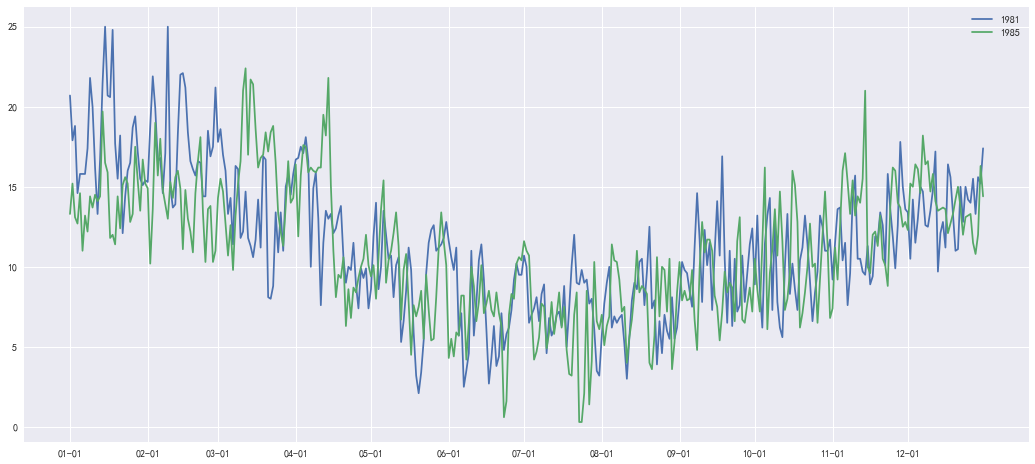

In [11]:
fig, ax = plt.subplots(figsize=(18, 8))
for year in data['year'].unique():
    if year in [1981,1985]:
        tmp=data[data['year']==year].copy()
        plt.plot(tmp['Date'].apply(lambda x:x.strftime('%m-%d')),tmp['Temp'],label=year)

plt.xticks([f'{i:02d}-01' for i in range(1,13)])
plt.legend()
plt.show()

In [13]:
from collections import Counter
outlier_date_counter=Counter()

for func in [outlier_detection_from_sigma_std,outlier_detection_from_sigma_box_plot,outlier_detection_from_kde]:
	outlier_data=func(data.set_index('Date')['Temp'])
	outlier_date_counter += Counter({i:1 for i in outlier_data.index})

	for year in data['year'].unique():
		outlier_data=func(data[data['year']==year].set_index('Date')['Temp'])
		outlier_date_counter += Counter({i:1 for i in outlier_data.index})

	for quarter in data['quarter'].unique():
		outlier_data=func(data[data['quarter']==quarter].set_index('Date')['Temp'])
		outlier_date_counter += Counter({i:1 for i in outlier_data.index})

	for month in data['month'].unique():
		outlier_data=func(data[data['month']==month].set_index('Date')['Temp'])
		outlier_date_counter += Counter({i:1 for i in outlier_data.index})

	for weeknum in data['weeknum'].unique():
		outlier_data=func(data[data['weeknum']==weeknum].set_index('Date')['Temp'])
		outlier_date_counter += Counter({i:1 for i in outlier_data.index})

	for date in data['date'].unique():
		outlier_data=func(data[data['date']==date].set_index('Date')['Temp'])
		outlier_date_counter += Counter({i:1 for i in outlier_data.index})

# sorted(outlier_date_counter.items(),key=lambda x:x[1],reverse=True)
data.loc[data['Date'].isin([i for i,j in outlier_date_counter.items() if j >= 3])]

,Date,Temp,year,month,week,weeknum,day,quarter,date
14,1981-01-15,25.0,1981,1,4,3,15,1,01-15
17,1981-01-18,24.8,1981,1,7,3,18,1,01-18
39,1981-02-09,25.0,1981,2,1,7,9,1,02-09
381,1982-01-17,24.0,1982,1,7,2,17,1,01-17
384,1982-01-20,25.2,1982,1,3,3,20,1,01-20
410,1982-02-15,26.3,1982,2,1,7,15,1,02-15
1425,1984-11-26,24.3,1984,11,1,48,26,4,11-26
1564,1985-04-14,21.8,1985,4,7,15,14,2,04-14
2460,1987-09-27,19.2,1987,9,7,39,27,3,09-27
2496,1987-11-02,23.0,1987,11,1,45,2,4,11-02


In [14]:
data.loc[data['Date'].isin([i for i,j in outlier_date_counter.items() if j >= 3]),'Temp'] = np.nan
data['Temp']=data['Temp'].interpolate()
data.loc[data['Date'].isin([i for i,j in outlier_date_counter.items() if j >= 3])]

,Date,Temp,year,month,week,weeknum,day,quarter,date
14,1981-01-15,21.10,1981,1,4,3,15,1,01-15
17,1981-01-18,19.15,1981,1,7,3,18,1,01-18
39,1981-02-09,16.05,1981,2,1,7,9,1,02-09
381,1982-01-17,16.90,1982,1,7,2,17,1,01-17
384,1982-01-20,20.10,1982,1,3,3,20,1,01-20
410,1982-02-15,20.50,1982,2,1,7,15,1,02-15
1425,1984-11-26,13.10,1984,11,1,48,26,4,11-26
1564,1985-04-14,16.65,1985,4,7,15,14,2,04-14
2460,1987-09-27,15.95,1987,9,7,39,27,3,09-27
2496,1987-11-02,17.20,1987,11,1,45,2,4,11-02


In [15]:
data[data['Date'].between(datetime.date(1981,1,12),datetime.date(1981,1,17))]

,Date,Temp,year,month,week,weeknum,day,quarter,date
11,1981-01-12,13.3,1981,1,1,3,12,1,01-12
12,1981-01-13,16.7,1981,1,2,3,13,1,01-13
13,1981-01-14,21.5,1981,1,3,3,14,1,01-14
14,1981-01-15,21.1,1981,1,4,3,15,1,01-15
15,1981-01-16,20.7,1981,1,5,3,16,1,01-16
16,1981-01-17,20.6,1981,1,6,3,17,1,01-17
